In [4]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(themis)
library(ggplot2)
library(yardstick)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Introduction
- 

### Background

Online games are not just pieces of software; they are communities. Servers rise and fall depending on how well they attract, inform, and retain players. One common tool for keeping players engaged is the humble newsletter: a regular email that announces updates, events, and community news. For a research or hobby server with limited resources, it is helpful to know which players are most likely to subscribe to such a newsletter so that communication strategies can be targeted and server features can be designed around the needs of the most engaged users.

Minecraft is a particularly interesting setting for this kind of question. It has a wide age range of players, different play styles, and varying levels of commitment—from casual visitors who log in once or twice to highly engaged players who accumulate hundreds of hours on a single server. Understanding how basic player characteristics relate to newsletter subscription can give us insight into patterns of engagement and could help server administrators make more informed decisions about outreach and design.

### Research Question

In this project, we focus on a specific, data-driven question about player engagement on a Minecraft research server:

Can we predict whether a player subscribes to the server’s email newsletter using their age, self-reported gender, and total hours played on the Minecraft research server?

More broadly, we are interested in:

What player characteristics and behaviours are most strongly associated with subscribing to a game-related newsletter?

We treat newsletter subscription as a proxy for deeper or more “committed” engagement with the server and the research community around it. Our goal is not only to build a predictive model, but also to interpret which variables appear most important and how they relate to the probability of subscribing.

### Dataset

To answer this question, we use data collected from a Minecraft research server. The original dataset is provided in two related comma-separated value (CSV) files:

players.csv – one row per unique player

sessions.csv – one row per play session

The two tables are linked through an anonymized identifier (hashedEmail), which allows session-level behaviour to be associated with individual players without exposing their personal information.

In players.csv, each row represents a single player who joined the research server. The variables available include:

Age (years): a numeric variable indicating the player’s self-reported age. There are some missing values in this column.

gender: a categorical variable recording the player’s self-reported gender.

played_hours: a numeric variable giving the total number of hours the player has spent on the server (summed across all their sessions).

subscribe: a logical (TRUE/FALSE) variable indicating whether the player opted in to receive the server’s email newsletter.

Additional identifier and name fields, which are not directly used in our analysis.

The sessions.csv file contains one row per play session, with information such as the player identifier and the duration of that session. This table can be used to reconstruct or verify total play time, and to derive more detailed behavioural features if needed (for example, number of sessions or average session length). In our analysis, we primarily rely on the aggregated per-player variable played_hours from players.csv, which already captures overall play time for each player.

The full dataset consists of approximately 1,500 players and over a thousand recorded sessions. Because players joined the research server voluntarily, the sample is likely biased towards people who are already relatively engaged with Minecraft and willing to participate in a study. There may also be age and gender imbalances depending on who chose to take part. In addition, several variables contain missing values (for example, some players did not report their age), which may reduce the effective sample size and could introduce bias if the missingness is systematic rather than random. These limitations mean that our findings should be interpreted as patterns within this particular research server population, rather than as definitive statements about all Minecraft players.

Despite these caveats, the dataset is well suited to our question. The response variable subscribe directly measures the behaviour we want to predict, and we have a small set of interpretable predictors (Age, gender, and total played_hours) that are available for most players. The data are in a tidy, tabular format compatible with standard modelling and visualization tools in Jupyter, and the sample size is large enough to fit and evaluate simple classification models.

In the remainder of the report, we will use this dataset to explore how newsletter subscription relates to player characteristics, build a predictive model for subscribe, and interpret what our results suggest about engagement on the Minecraft research server.

Data wrangling
- 

In [5]:
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Can we predict whether a player subscribes to the server’s email newsletter using their age, self-reported gender, and total hours played on the Minecraft research server?

In [6]:
players_clean <- players|>
        mutate(
            subscribe = as.factor(subscribe),
           experience = case_when(
                experience == "Beginner" ~ 1,
               experience == "Amateur" ~ 2,
               experience == "Regular" ~ 3,
               experience == "Veteran" ~ 4,
               experience == "Pro" ~ 5),
            gender = case_when(
                gender == "Male" ~ 1,
                gender == "Female" ~ 2,
                gender == "Non-binary" ~ 3,
                gender == "Two-Spirited" ~ 4,
                gender == "Agender" ~ 5,
                gender == "Prefer not to say" ~ 6) 
            )|>
        drop_na() 

In [23]:
players_clean_viz <- players|>
           mutate(
            subscribe = as.factor(subscribe),
            experience = factor(
                experience,
                levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")
                ),
           gender = factor(
               gender,
               levels = c("Male", "Female", "Non-binary", "Two-Spritied", "Agender", "Prefer not to say")
           ))|>
        drop_na() 

#Make a dataset specifically for visualisation because the categories were turned into numbers for the knn classification

Data visualisation
-

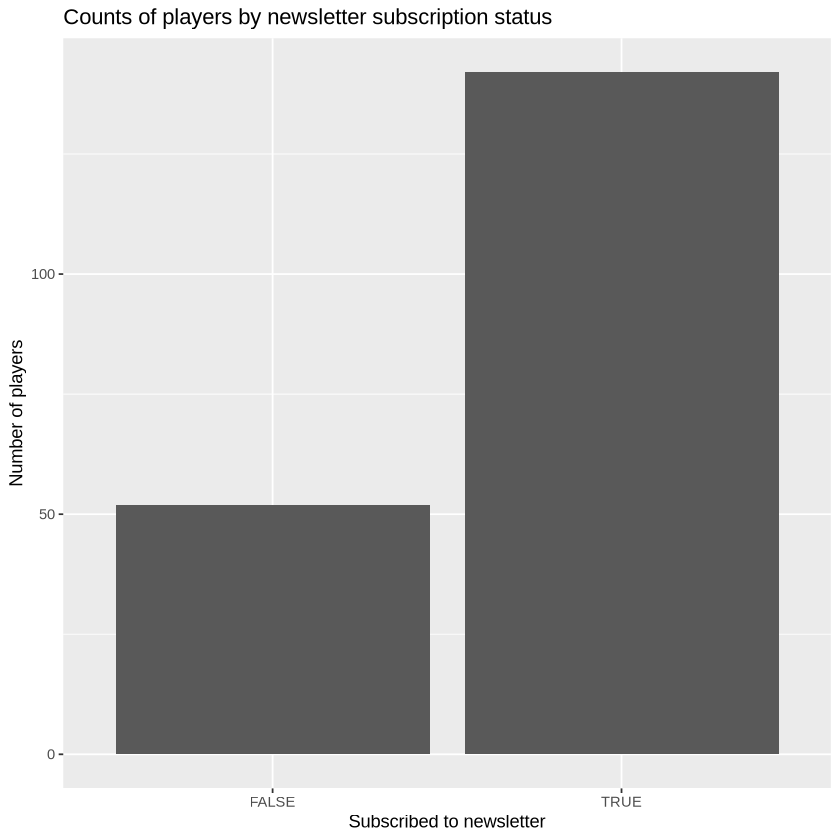

In [8]:
players_clean |>
    ggplot(aes(x = subscribe)) +
    geom_bar() +
    labs(
        title = "Counts of players by newsletter subscription status", 
        x = "Subscribed to newsletter",
        y = "Number of players"
        )

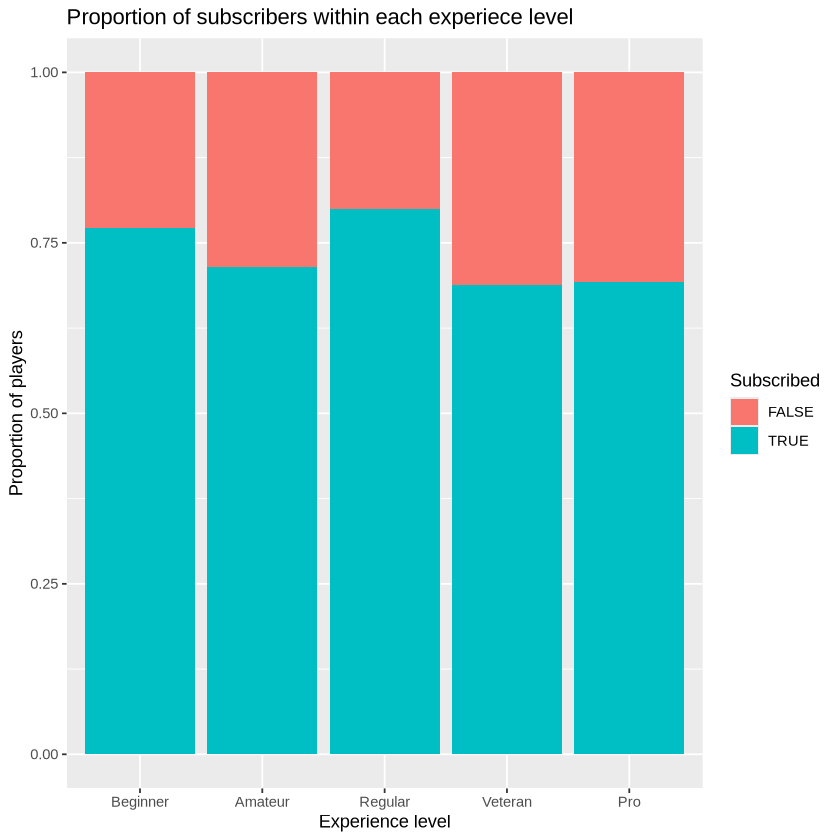

In [9]:
players_clean_viz |>
    ggplot(aes(x = experience, fill = subscribe))+
    geom_bar(position = "fill") + 
    labs(
        title = "Proportion of subscribers within each experiece level",
        x = "Experience level",
        y = "Proportion of players",
        fill = "Subscribed"
        )

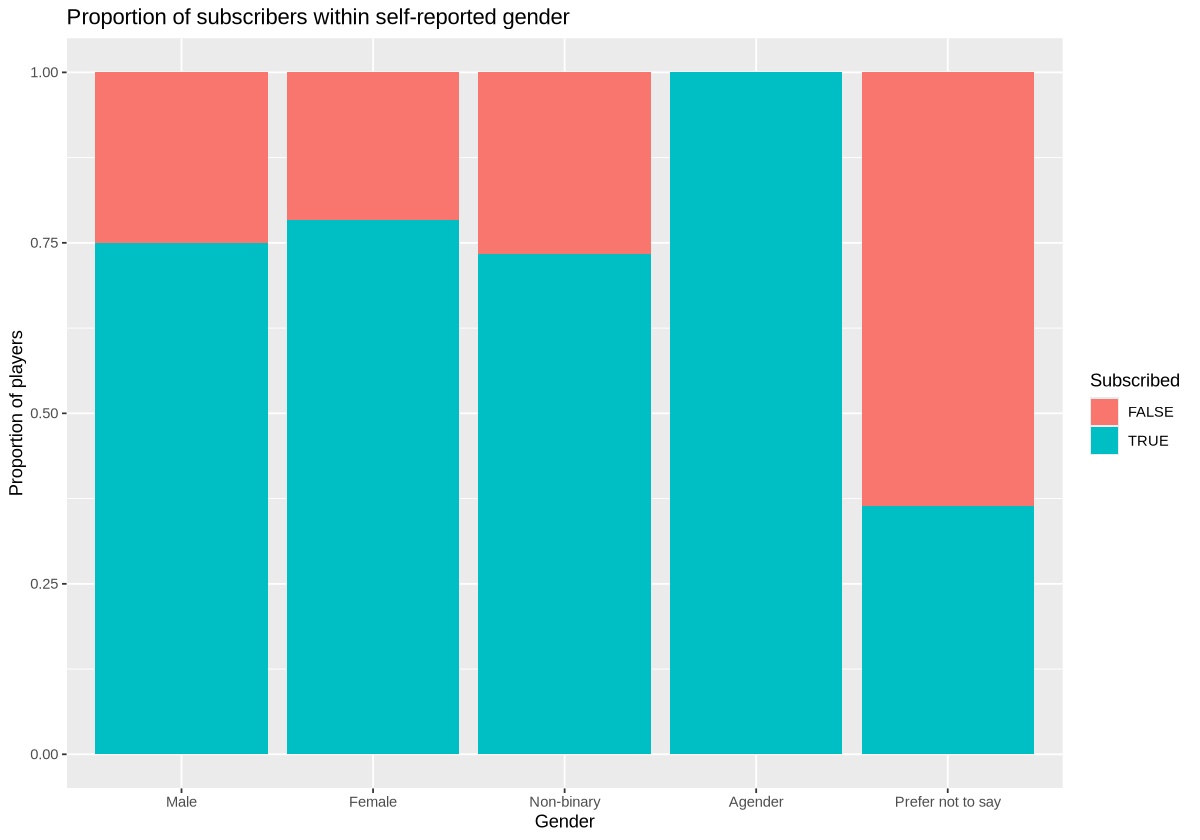

In [22]:
players_clean_viz |>
    ggplot(aes(x = gender, fill = subscribe))+
    geom_bar(position = "fill") + 
    labs(
        title = "Proportion of subscribers within self-reported gender",
        x = "Gender",
        y = "Proportion of players",
        fill = "Subscribed"
        )

### Analysis

Roughly three quarters of players subscribed to the newsletter. Subscribers tend to have much higher played_hours than non-subscribers, while the Age distributions overlap but non-subscribers look slightly older on average. Expereince levels all show relatively high subscription rates. Most genders have a higher subscription rate than not, the "prefer not to say" category being an execption. These patterns suggest that playtime, experience, and gender should be informative predictors, and also confirm that there are some extreme playtime values to keep in mind for distance-based methods.

KNN classification seems to be the right path as the outcome is binary and it makes few parametric assumptions. It assumes that the players with similar subscription behavior and that predictors are on comparable scales. Limitations include sensitivity to the choice of k, possible class imbalance, and lower interpretability compared to parametric models. The class imbalance can be somewhat managed with code, though.

KNN-Classification
-

In [11]:
set.seed(3456)
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)  
player_train <- training(player_split)   
player_test <- testing(player_split)

In [12]:
options(warn = -1)
player_recipe <- recipe(subscribe ~ Age + played_hours + gender , data = player_train) |>
step_dummy(all_nominal_predictors())|>
step_scale(all_predictors()) |>
step_center(all_predictors())|>
step_upsample(subscribe, over_ratio = 1) #to fix the class imbalance
player_recipe 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5)) 



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Dummy variables from: all_nominal_predictors()

• Scaling for: all_predictors()

• Centering for: all_predictors()

• Up-sampling based on: subscribe



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4625123,5,0.04245954,Preprocessor1_Model01
1,roc_auc,binary,0.4307900,5,0.06269047,Preprocessor1_Model01
6,accuracy,binary,0.4751232,5,0.02153729,Preprocessor1_Model02
6,roc_auc,binary,0.5095315,5,0.05021452,Preprocessor1_Model02
11,accuracy,binary,0.5308374,5,0.04964325,Preprocessor1_Model03
11,roc_auc,binary,0.5229399,5,0.05947323,Preprocessor1_Model03
16,accuracy,binary,0.5384401,5,0.01745610,Preprocessor1_Model04
16,roc_auc,binary,0.5146297,5,0.04501852,Preprocessor1_Model04
21,accuracy,binary,0.6002791,5,0.03604811,Preprocessor1_Model05


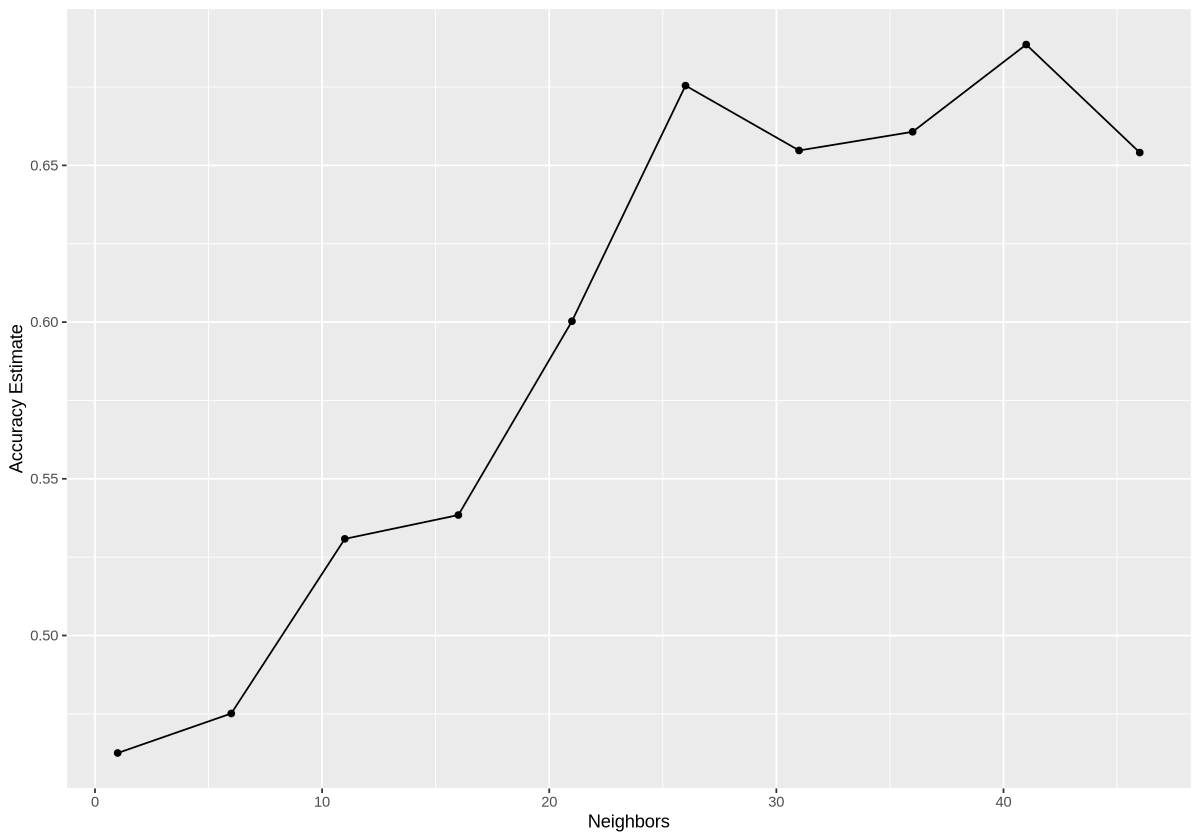

In [13]:
options(warn = 0)
options(repr.plot.height = 7, repr.plot.width = 10)
knn_results <- workflow() |> 
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = player_vfold, grid = k_vals) |>
       collect_metrics()
knn_results

accuracy <- knn_results|>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
accuracy_vs_k

In [14]:
best_k <- accuracy |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 41

In [15]:
best_player_recipe <- recipe(subscribe ~ Age + played_hours + gender, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) #remake model with the best k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(best_player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)

player_test_predictions <- predict(knn_fit, player_test) |>
  bind_cols(player_test)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
player_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
TRUE,2,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,2,21
TRUE,3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,1,21
TRUE,2,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,2,17
TRUE,2,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,1,47
TRUE,5,TRUE,4caa42e1b20511552434978171dcf7283fb6eb857eb871327e39bfc328002309,0.0,Daniela,1,17
TRUE,2,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,2,17
TRUE,3,TRUE,5baba1651a0b92788bc0d6dcdf00be64af1cf9f0015bbeed204ddabd1d872e83,0.6,Kendall,2,28
TRUE,2,TRUE,4b01bce3f141289709e8278b02ba5d2aaa7105d7ccb9c7deb37670a80e332774,1.8,Luca,1,23
TRUE,1,TRUE,f459ce1862ec9a43b6c714810390dfd632ed104eb11378b3a2a134b1b107bc75,0.6,Jabari,1,26


In [16]:
confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

In [17]:
precision <- 36/36
precision
recall <- 36/(36+13)
recall

[1] 1

[1] 0.7346939

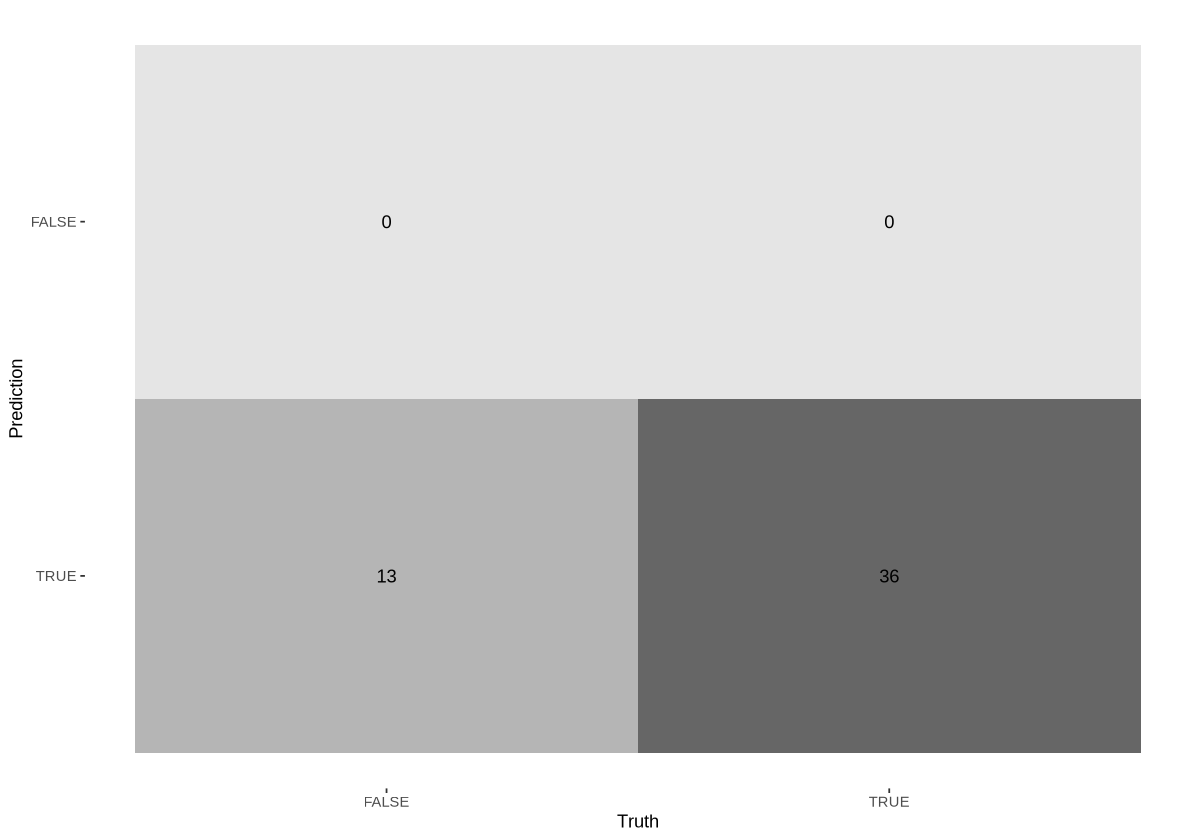

In [18]:
autoplot(confusion, type = "heatmap")

Discussion
- 

The question we wanted to answer was whether a player's age, self-reported gender, and total hours played could predict whether a player was subscribed to the email newsletter or not. Through the use of K-Nearest-Neighbors (KNN), the model achieved an accuracy of around 73.5%, indicating that it made generally accurate predictions. Out of the test data, 36 players were correctly predicted as subscribed, 13 players were incorrectly predicted as subscribed, and 0 players were correctly or incorrectly predicted as not subscribed. The model predicted everyone as subscribed and did not identify any non-subscribers. This could be because factors such as age, gender, and hours played may not be enough to accurately predict non-subscribers. 

The results were somewhat expected because it makes sense that the model predicted most players as subscribed. This is because players who spend more time on the server are likely to be more engaged and therefore more likely to subscribe to the newsletter. However, it is more difficult to predict whether there is a correlation between age, gender, and subscription status. It was also unexpected how the model predicted every player as subscribed and not a single player as non-subscribed. The summary statistics show that players average 5.85 hours on the server, with a wide range of ages and hours played. The variation could suggest that engagement and subscription status are not limited to a specific demographic, suggesting there could be other factors that influence the subscription status. 

This model could be used in real life because it is successfully able to identify players who are likely to subscribe. This could help the server understand which type of players are more engaged and could be used to better player experiences or tailor content and experiences that appeal to more committed players. The results could additionally improve communication methods with users. Furthermore, identifying patterns among likely subscribers could allow for strategies to attract more users to the newsletter. Moreover, this approach provides a framework for monitoring engagement trends over time and potentially guiding decisions about community-building efforts or increasing participation incentives.

Some future questions this could lead to are whether there are any other predictors beyond age, gender, and hours played that could better predict the status of the subscription. What additional variables could we add, or how could changing the model help to identify non-subscribers and subscribers more accurately? Finally, understanding why some players do not subscribe, despite being active, could inform communication strategies for different types of players.